In [1]:
import warnings
warnings.simplefilter('ignore')

# 1. Install and Import Dependencies

In [5]:
!conda install -c conda-forge prophet -y

Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\User\anaconda3

  added / updated specs:
    - prophet


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-22.11.1              |   py39hcbf5309_1         908 KB  conda-forge
    convertdate-2.4.0          |     pyhd8ed1ab_0          38 KB  conda-forge
    ephem-4.1.3                |   py39hb82d6ee_4         1.3 MB  conda-forge
    hijri-converter-2.2.4      |     pyhd8ed1ab_0          18 KB  conda-forge
    holidays-0.17.2            |     pyhd8ed1ab_0          98 KB  conda-forge
    lunarcalendar-0.0.9        |             py_0          20 KB  conda-forge
    prophet-1.0.1              |   py39haa95532_0         523 KB
    pymeeus-0.5.12             |     pyhd8ed1ab_0         507 KB  conda-forge
    setuptools-git-1.2         |             py_1      

# 2. Load and Filter Data

In [6]:
import pandas as pd 

In [12]:
df = pd.read_csv('dataset.csv')
df = df[(df['Product']=='TESLA_MODEL_X') & (df['Store']=='LOS_ANGELES')]

In [16]:
df.head()

,Date,Store,Product,Value
0,20180101,LOS_ANGELES,TESLA_MODEL_X,2926.000
1,20180102,LOS_ANGELES,TESLA_MODEL_X,2687.531
2,20180103,LOS_ANGELES,TESLA_MODEL_X,2793.000
3,20180104,LOS_ANGELES,TESLA_MODEL_X,2394.000
4,20180105,LOS_ANGELES,TESLA_MODEL_X,2660.000


In [17]:
df.Store.unique()

array(['LOS_ANGELES'], dtype=object)

In [18]:
df.Product.unique()

array(['TESLA_MODEL_X'], dtype=object)

# 3. Preprocess and Create Partitions

## Create Dates

In [24]:
df.head(25)

,Date,Store,Product,Value
0,20180101,LOS_ANGELES,TESLA_MODEL_X,2926.0000
1,20180102,LOS_ANGELES,TESLA_MODEL_X,2687.5310
2,20180103,LOS_ANGELES,TESLA_MODEL_X,2793.0000
3,20180104,LOS_ANGELES,TESLA_MODEL_X,2394.0000
4,20180105,LOS_ANGELES,TESLA_MODEL_X,2660.0000
5,20180106,LOS_ANGELES,TESLA_MODEL_X,2527.0000
6,20180107,LOS_ANGELES,TESLA_MODEL_X,2527.0000
7,20180108,LOS_ANGELES,TESLA_MODEL_X,2793.0000
8,20180109,LOS_ANGELES,TESLA_MODEL_X,2793.0000
9,20180110,LOS_ANGELES,TESLA_MODEL_X,2793.0000


In [25]:
df['ds'] = pd.to_datetime(df.Date, format='%Y%m%d')

In [33]:
df['day'] = df['ds'].dt.day
df['month'] = df['ds'].dt.month
df['year'] = df['ds'].dt.year

In [35]:
df = df.drop(['Date','Store','Product','day','month','year'], axis=1)

In [38]:
df.columns = ['y','ds']

In [36]:
df.dtypes

Value           float64
ds       datetime64[ns]
dtype: object

In [39]:
df.head(25)

,y,ds
0,2926.0000,2018-01-01
1,2687.5310,2018-01-02
2,2793.0000,2018-01-03
3,2394.0000,2018-01-04
4,2660.0000,2018-01-05
5,2527.0000,2018-01-06
6,2527.0000,2018-01-07
7,2793.0000,2018-01-08
8,2793.0000,2018-01-09
9,2793.0000,2018-01-10


## Visualise the Data to Determine Appropriate Partitions

In [40]:
import seaborn as sns
from matplotlib import pyplot as plt

In [41]:
%matplotlib inline

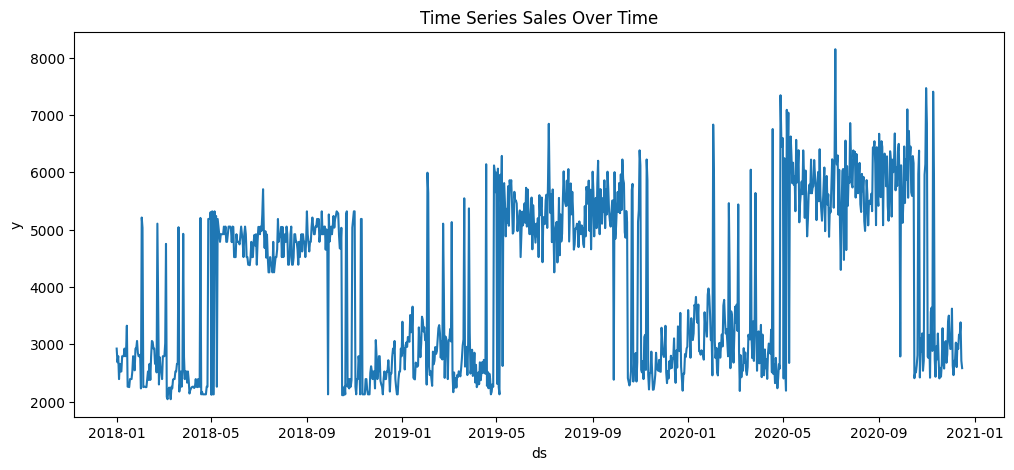

In [46]:
plt.figure(figsize=(12,5))
sns.lineplot(x='ds', y='y', data=df).set_title('Time Series Sales Over Time')
plt.show()

## Create Train and Test Splits

In [47]:
df['ds'].min()

Timestamp('2018-01-01 00:00:00')

In [48]:
df['ds'].max()

Timestamp('2020-12-16 00:00:00')

In [49]:
train = df[df['ds'] < '2020-06-30 00:00:00']
test = df[df['ds'] >= '2020-06-30 00:00:00']

In [51]:
train.shape

(910, 2)

In [53]:
test.shape

(170, 2)

In [54]:
170/(910+170)

0.1574074074074074

# 4. Train Model

In [55]:
from prophet import Prophet

In [57]:
m = Prophet()
model = m.fit(train)

06:43:44 - cmdstanpy - INFO - Chain [1] start processing
06:43:44 - cmdstanpy - INFO - Chain [1] done processing


# 5. Evaluate Model

## Make Predictions on Test Set

In [59]:
from sklearn.metrics import mean_absolute_error

In [63]:
yhat = m.predict(test[['ds']])

In [64]:
yhat

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-30,4355.736238,4494.271192,6509.002379,4355.736238,4355.736238,1113.301358,1113.301358,1113.301358,-7.935386,-7.935386,-7.935386,1121.236744,1121.236744,1121.236744,0.0,0.0,0.0,5469.037596
1,2020-07-01,4356.681356,4475.135116,6447.069816,4356.681356,4356.681356,1099.106253,1099.106253,1099.106253,-13.477032,-13.477032,-13.477032,1112.583285,1112.583285,1112.583285,0.0,0.0,0.0,5455.787610
2,2020-07-02,4357.626475,4522.974229,6478.512207,4357.626475,4357.626475,1121.360830,1121.360830,1121.360830,15.737098,15.737098,15.737098,1105.623732,1105.623732,1105.623732,0.0,0.0,0.0,5478.987305
3,2020-07-03,4358.571593,4362.111902,6413.499624,4358.571593,4358.571593,1061.175123,1061.175123,1061.175123,-39.351738,-39.351738,-39.351738,1100.526861,1100.526861,1100.526861,0.0,0.0,0.0,5419.746716
4,2020-07-04,4359.516711,4414.641066,6446.165520,4359.516711,4359.516711,1071.483973,1071.483973,1071.483973,-25.910997,-25.910997,-25.910997,1097.394970,1097.394970,1097.394970,0.0,0.0,0.0,5431.000684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,2020-12-12,4511.680764,2092.570956,4165.576020,4511.672854,4511.688658,-1386.365544,-1386.365544,-1386.365544,-25.910997,-25.910997,-25.910997,-1360.454547,-1360.454547,-1360.454547,0.0,0.0,0.0,3125.315220
166,2020-12-13,4512.625882,2237.553105,4246.694850,4512.617866,4512.633861,-1296.776268,-1296.776268,-1296.776268,47.692880,47.692880,47.692880,-1344.469148,-1344.469148,-1344.469148,0.0,0.0,0.0,3215.849614
167,2020-12-14,4513.571000,2221.454089,4209.027379,4513.562910,4513.579069,-1306.037216,-1306.037216,-1306.037216,23.245174,23.245174,23.245174,-1329.282390,-1329.282390,-1329.282390,0.0,0.0,0.0,3207.533784
168,2020-12-15,4514.516119,2209.972858,4160.283866,4514.507961,4514.524280,-1322.930387,-1322.930387,-1322.930387,-7.935386,-7.935386,-7.935386,-1314.995001,-1314.995001,-1314.995001,0.0,0.0,0.0,3191.585732


In [66]:
mean_absolute_error(test[['y']], yhat[['yhat']])

702.3626926248282

## Make New Predictions

In [71]:
test.tail()

,y,ds
1075,3167.594500,2020-12-12
1076,3167.594500,2020-12-13
1077,3383.354511,2020-12-14
1078,2714.591329,2020-12-15
1079,2585.035107,2020-12-16


In [74]:
future.tail()

,ds
1405,2021-11-07
1406,2021-11-08
1407,2021-11-09
1408,2021-11-10
1409,2021-11-11


In [81]:
future = m.make_future_dataframe(periods=1000, freq='D')
forecast = m.predict(future) 
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1905,2023-03-22,5296.128983,3327.432292,5348.549215,5296.004620,5296.262849,-984.943978,-984.943978,-984.943978,-13.477032,-13.477032,-13.477032,-971.466946,-971.466946,-971.466946,0.0,0.0,0.0,4311.185006
1906,2023-03-23,5297.074101,3320.993372,5355.688050,5296.949615,5297.208186,-944.200015,-944.200015,-944.200015,15.737098,15.737098,15.737098,-959.937113,-959.937113,-959.937113,0.0,0.0,0.0,4352.874086
1907,2023-03-24,5298.019220,3395.931676,5373.490781,5297.894610,5298.153522,-990.645100,-990.645100,-990.645100,-39.351738,-39.351738,-39.351738,-951.293363,-951.293363,-951.293363,0.0,0.0,0.0,4307.374119
1908,2023-03-25,5298.964338,3354.877545,5356.598970,5298.839605,5299.098853,-972.049124,-972.049124,-972.049124,-25.910997,-25.910997,-25.910997,-946.138127,-946.138127,-946.138127,0.0,0.0,0.0,4326.915214
1909,2023-03-26,5299.909456,3418.291462,5283.554946,5299.784608,5300.044184,-897.293868,-897.293868,-897.293868,47.692880,47.692880,47.692880,-944.986748,-944.986748,-944.986748,0.0,0.0,0.0,4402.615588


In [82]:
forecast[['ds', 'yhat_lower', 'yhat', 'yhat_upper']].tail()

,ds,yhat_lower,yhat,yhat_upper
1905,2023-03-22,3327.432292,4311.185006,5348.549215
1906,2023-03-23,3320.993372,4352.874086,5355.688050
1907,2023-03-24,3395.931676,4307.374119,5373.490781
1908,2023-03-25,3354.877545,4326.915214,5356.598970
1909,2023-03-26,3418.291462,4402.615588,5283.554946


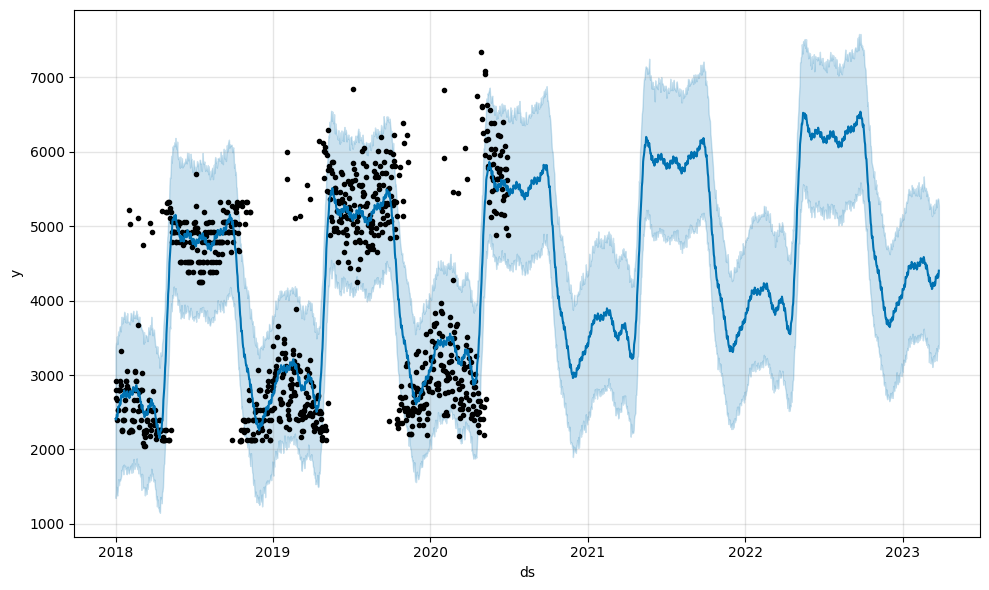

In [83]:
plot1 = m.plot(forecast)

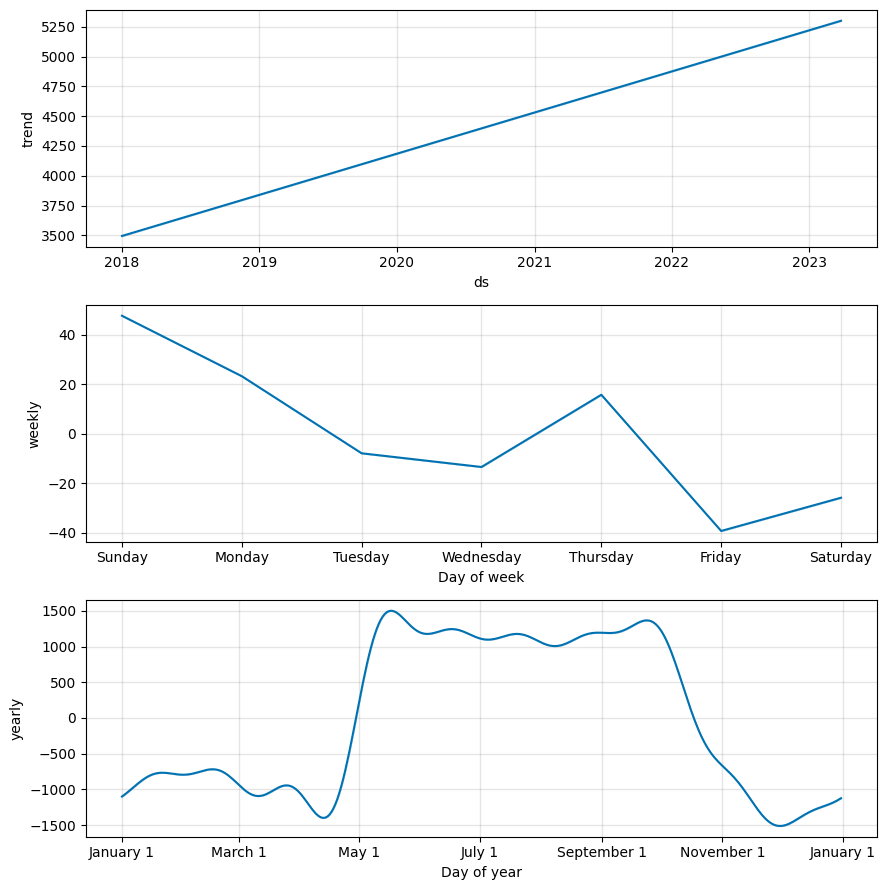

In [84]:
plot2 = m.plot_components(forecast)

# 6. Save Model

In [86]:
import json
from prophet.serialize import model_to_json, model_from_json

In [87]:
with open('serialized_model.json', 'w') as fout: 
    json.dump(model_to_json(m), fout)

In [89]:
del m

In [92]:
with open('serialized_model.json', 'r') as fin: 
    m = model_from_json(json.load(fin))

In [94]:
future = m.make_future_dataframe(periods=100, freq='D')
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1005,2020-10-03,4445.522480,4564.612818,6574.136122,4445.519322,4445.525714,1079.451655,1079.451655,1079.451655,-25.910997,-25.910997,-25.910997,1105.362651,1105.362651,1105.362651,0.0,0.0,0.0,5524.974135
1006,2020-10-04,4446.467598,4449.099628,6511.196049,4446.464370,4446.470894,1093.304107,1093.304107,1093.304107,47.692880,47.692880,47.692880,1045.611227,1045.611227,1045.611227,0.0,0.0,0.0,5539.771705
1007,2020-10-05,4447.412717,4398.588642,6436.246920,4447.409436,4447.416084,1003.640061,1003.640061,1003.640061,23.245174,23.245174,23.245174,980.394888,980.394888,980.394888,0.0,0.0,0.0,5451.052778
1008,2020-10-06,4448.357835,4363.056226,6357.547289,4448.354502,4448.361272,902.289204,902.289204,902.289204,-7.935386,-7.935386,-7.935386,910.224589,910.224589,910.224589,0.0,0.0,0.0,5350.647039
1009,2020-10-07,4449.302953,4210.618446,6298.943267,4449.299564,4449.306445,822.221416,822.221416,822.221416,-13.477032,-13.477032,-13.477032,835.698448,835.698448,835.698448,0.0,0.0,0.0,5271.524369


# 7. Create models for each combo

## Process Entire Dataframe

In [96]:
df = pd.read_csv('dataset.csv')

In [99]:
df['ds'] = pd.to_datetime(df['Date'], format='%Y%m%d')

In [102]:
df.head()

,Date,Store,Product,Value,ds
0,20180101,LOS_ANGELES,TESLA_MODEL_X,2926.000,2018-01-01
1,20180102,LOS_ANGELES,TESLA_MODEL_X,2687.531,2018-01-02
2,20180103,LOS_ANGELES,TESLA_MODEL_X,2793.000,2018-01-03
3,20180104,LOS_ANGELES,TESLA_MODEL_X,2394.000,2018-01-04
4,20180105,LOS_ANGELES,TESLA_MODEL_X,2660.000,2018-01-05


## Create Model Building Function

In [109]:
def build_model(df, product, store): 
    # Filter dataframe on a specific product and store
    abt = df[(df['Product']==product) & (df['Store']==store)]
    abt = abt.drop(['Date','Store','Product'], axis=1) 
    abt.columns = ['y','ds']
    
    # Fit the prophet model on all the data 
    m = Prophet()
    model = m.fit(abt) 
    
    # Save Model 
    with open(f'serialized_model_{product}_{store}.json', 'w') as fout: 
        json.dump(model_to_json(m), fout)
    
    return f'Model fit for {product} and {store}'

In [118]:
build_model(df, 'TESLA_MODEL_X', 'SAN_FRANCISCO')

07:38:32 - cmdstanpy - INFO - Chain [1] start processing
07:38:32 - cmdstanpy - INFO - Chain [1] done processing


'Model fit for TESLA_MODEL_X and SAN_FRANCISCO'

In [119]:
with open('serialized_model_TESLA_MODEL_X_SAN_FRANCISCO.json', 'r') as fin: 
    reloaded_model = model_from_json(json.load(fin))

In [123]:
refuture = reloaded_model.make_future_dataframe(periods=1000, freq='D')
reforecast = reloaded_model.predict(refuture)

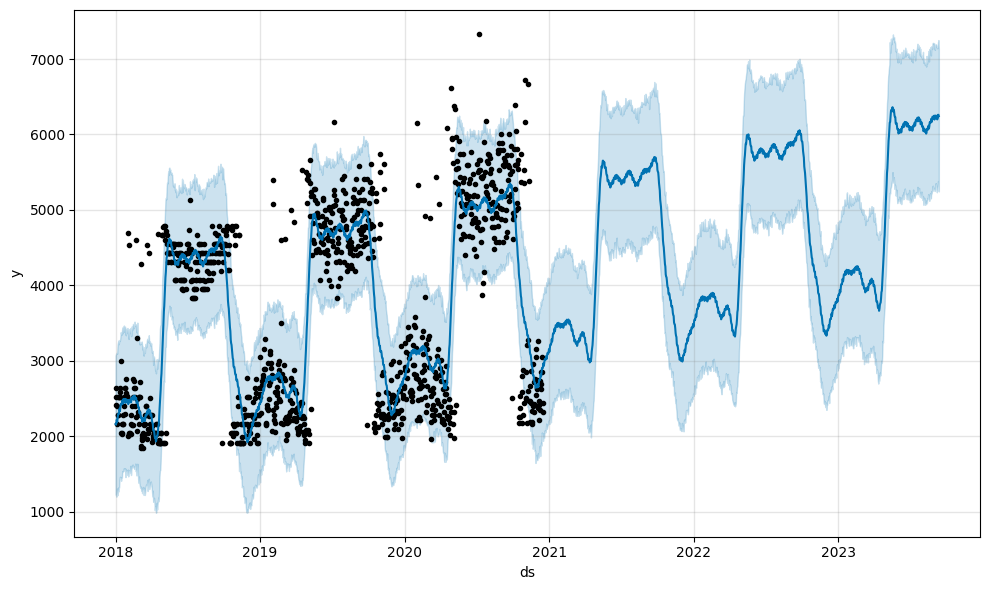

In [124]:
plotx = reloaded_model.plot(reforecast)

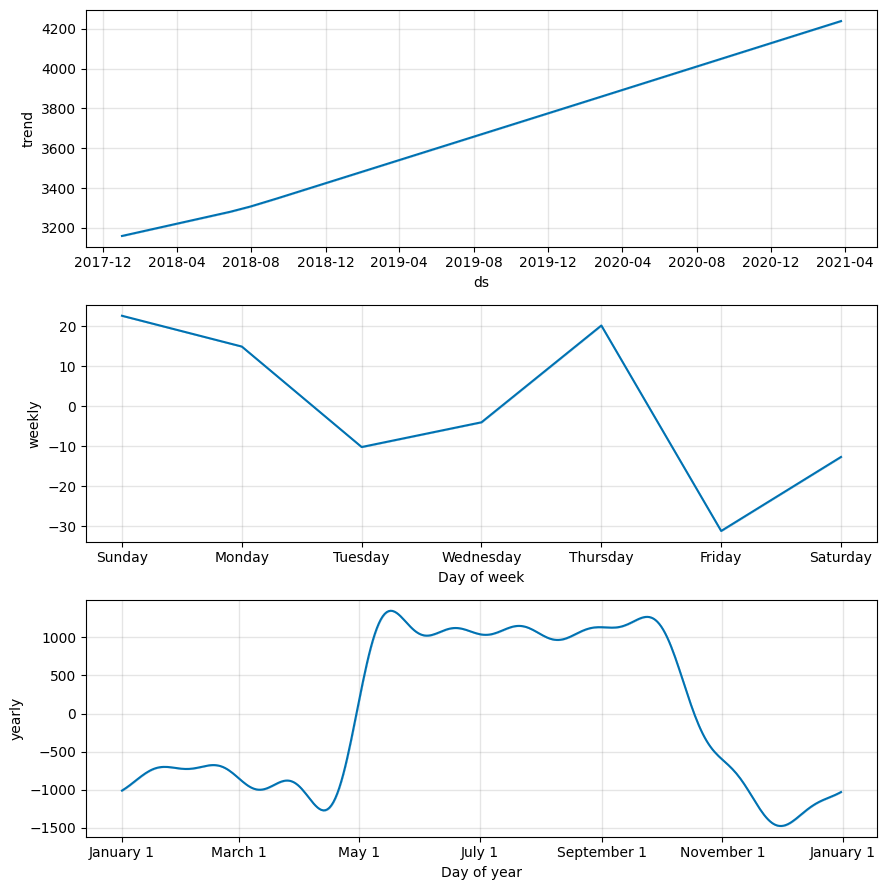

In [121]:
plot1 = reloaded_model.plot_components(reforecast)

## Loop Through All the Store and Vehicle Combinations

In [125]:
import itertools

In [132]:
display(df['Store'].unique(), df['Product'].unique())

array(['LOS_ANGELES', 'SAN_FRANCISCO'], dtype=object)

array(['TESLA_MODEL_X', 'TESLA_MODEL_S'], dtype=object)

In [135]:
for product, store in itertools.product(df['Product'].unique(), df['Store'].unique()):
    print(build_model(df, product, store))

07:47:53 - cmdstanpy - INFO - Chain [1] start processing
07:47:53 - cmdstanpy - INFO - Chain [1] done processing
07:47:53 - cmdstanpy - INFO - Chain [1] start processing


Model fit for TESLA_MODEL_X and LOS_ANGELES


07:47:53 - cmdstanpy - INFO - Chain [1] done processing
07:47:54 - cmdstanpy - INFO - Chain [1] start processing


Model fit for TESLA_MODEL_X and SAN_FRANCISCO


07:47:54 - cmdstanpy - INFO - Chain [1] done processing


Model fit for TESLA_MODEL_S and LOS_ANGELES


07:47:54 - cmdstanpy - INFO - Chain [1] start processing
07:47:54 - cmdstanpy - INFO - Chain [1] done processing


Model fit for TESLA_MODEL_S and SAN_FRANCISCO


In [147]:
with open('serialized_model_TESLA_MODEL_S_LOS_ANGELES.json', 'r') as fin: 
    reloaded_model = model_from_json(json.load(fin))

In [148]:
future = reloaded_model.make_future_dataframe(periods=120, freq='D')
forecast = reloaded_model.predict(future)

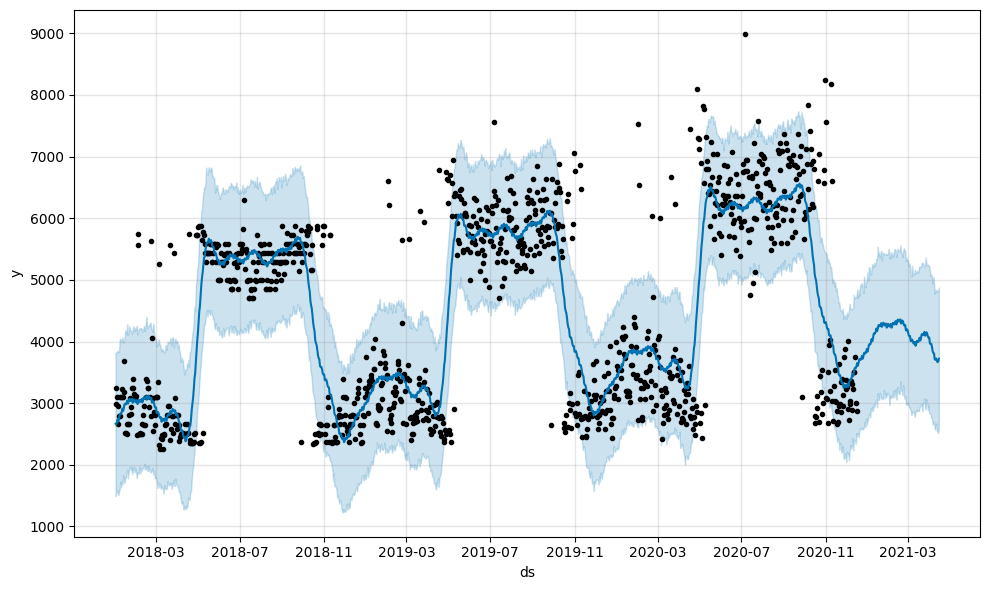

In [149]:
p = reloaded_model.plot(forecast)

# 8. Build Anvil App

## Create Notebook Uplink

In [152]:
!pip install anvil-uplink

     ---------------------------------------- 88.0/88.0 KB ? eta 0:00:00
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
  Using cached ws4py-0.5.1.tar.gz (51 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached future-0.18.2-py3-none-any.whl
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45238 sha256=f894ddce521895ddbdc6c44ec729115b8f475cfb10f18be64aa3c084f4d0cc34
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\e8\9d\fd\0a594a1bc8d493935d319ac40d64d79f5b4117ef4d37b1b678
Successfully built ws4py


You should consider upgrading via the 'D:\Full Stack Machine Learning\fullstack\Scripts\python.exe -m pip install --upgrade pip' command.


In [153]:
import os
import anvil.server

In [151]:
os.listdir('.')

['.ipynb_checkpoints',
 'dataset.csv',
 'Facebook Prophet.ipynb',
 'serialized_model.json',
 'serialized_model_TESLA_MODEL_S_LOS_ANGELES.json',
 'serialized_model_TESLA_MODEL_S_SAN_FRANCISCO.json',
 'serialized_model_TESLA_MODEL_X_LOS_ANGELES.json',
 'serialized_model_TESLA_MODEL_X_SAN_FRANCISCO.json']

In [154]:
anvil.server.connect("server_OT4SNHD66XNAP5N23ZKEOEO2-QVLLMTPZ46ARDLOK")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


## Build a Jupyter Callable Function

In [160]:
# Decorator for Anvil uplink
@anvil.server.callable
def forecast_future(model, timeframe): 
    
    # Load the model from the disc
    with open(model, 'r') as f: 
        m = model_from_json(json.load(f))
    
    # Make a prediction
    future = m.make_future_dataframe(periods=int(timeframe), freq='D')
    forecast = m.predict(future) 
    
    # Filtered the data we return back to the user
    forecast = forecast[['ds','yhat_lower','yhat', 'yhat_upper']]
    records = forecast.to_dict(orient='records')
    
    # Grab the columns to set column names in the Data Grid
    columns = list(forecast.columns)
    
    return columns, records

In [157]:
columns, records = forecast_future('serialized_model_TESLA_MODEL_S_LOS_ANGELES.json', 50)

In [159]:
[{'id':col, 'title':col, 'data_key':col } for col in columns]

[{'id': 'ds', 'title': 'ds', 'data_key': 'ds'},
 {'id': 'yhat_lower', 'title': 'yhat_lower', 'data_key': 'yhat_lower'},
 {'id': 'yhat', 'title': 'yhat', 'data_key': 'yhat'},
 {'id': 'yhat_upper', 'title': 'yhat_upper', 'data_key': 'yhat_upper'}]

## Add Client Side Scripts